In [29]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [3]:
os.getcwd()

'e:\\Bootcamp\\DS_Grupo3\\src\\model'

In [2]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
folder_path = 'Data'
file_name = 'train_stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_train = pd.read_csv(file_path)

parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
folder_path = 'Data'
file_name = 'test_stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_test = pd.read_csv(file_path)

In [3]:
y_train = df_train['stroke']
X_train = df_train.drop(['stroke'], axis=1).astype(int)

y_test = df_test['stroke']
X_test = df_test.drop(['stroke'], axis=1).astype(int)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [33]:
X = X_train
y = y_train
def safe_f1_score(precisions, recalls):
    # Evita la división por cero y maneja valores NaN
    f1_scores = np.zeros_like(precisions)
    valid = (precisions + recalls) > 0
    f1_scores[valid] = 2 * (precisions[valid] * recalls[valid]) / (precisions[valid] + recalls[valid])
    return f1_scores

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'random_state': 42,
        'eval_metric': 'auc'
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    scores = []
    thresholds = []
    
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model = XGBClassifier(**params, early_stopping_rounds=50)
        model.fit(
            X_train, 
            y_train, 
            eval_set=[(X_val, y_val)], 
            verbose=0
        )
        
        y_prob = model.predict_proba(X_val)[:, 1]
        
        # Ajuste fino del umbral con manejo de errores
        precisions, recalls, thresholds_fold = precision_recall_curve(y_val, y_prob)
        f1_scores = safe_f1_score(precisions, recalls)
        
        if np.isnan(f1_scores).all():
            print(f"Advertencia: Todos los F1-scores son NaN en el fold {fold}")
            best_threshold_fold = 0.5  # Umbral por defecto
        else:
            best_threshold_fold = thresholds_fold[np.nanargmax(f1_scores[:-1])]  # Usamos nanargmax para ignorar NaNs
        
        thresholds.append(best_threshold_fold)
        y_pred = (y_prob > best_threshold).astype(int)
        
        auc = roc_auc_score(y_val, y_prob)
        f1 = f1_score(y_val, y_pred)
        scores.append((auc + f1) / 2)  # Promedio de AUC y F1-score
        
        print(f"Fold {fold}: AUC = {auc:.4f}, F1 = {f1:.4f}, Best Threshold = {best_threshold:.4f}")
    
    trial.set_user_attr('best_threshold', np.mean(thresholds))
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_threshold = study.best_trial.user_attrs['best_threshold']

final_model = XGBClassifier(**best_params, early_stopping_rounds=50)
final_model.fit(X, y, eval_set=[(X, y)])

y_prob = final_model.predict_proba(X)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]


# Función para predecir usando el mejor umbral
def predict_with_threshold(model, X, threshold=best_threshold):
    y_prob = model.predict_proba(X)[:, 1]
    return (y_prob > threshold).astype(int)

[I 2024-10-20 03:47:07,184] A new study created in memory with name: no-name-cce9c140-3e37-48d1-8f42-6da2c56dc826


Fold 0: AUC = 0.8353, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8104, F1 = 0.7625, Best Threshold = 0.5805
Fold 3: AUC = 0.8412, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:08,069] Trial 0 finished with value: 0.7981841284278642 and parameters: {'n_estimators': 323, 'learning_rate': 0.1520278141131272, 'max_depth': 9, 'reg_alpha': 0.30584216190625585, 'reg_lambda': 0.030222935715226648, 'scale_pos_weight': 7.393613117655776}. Best is trial 0 with value: 0.7981841284278642.


Fold 4: AUC = 0.8207, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7706, Best Threshold = 0.5805
Fold 1: AUC = 0.8139, F1 = 0.7740, Best Threshold = 0.5805
Fold 2: AUC = 0.8075, F1 = 0.7633, Best Threshold = 0.5805


[I 2024-10-20 03:47:09,326] Trial 1 finished with value: 0.7958759831516745 and parameters: {'n_estimators': 838, 'learning_rate': 0.23121738144617066, 'max_depth': 10, 'reg_alpha': 3.725870885801337, 'reg_lambda': 30.036066619649873, 'scale_pos_weight': 7.537536406381118}. Best is trial 0 with value: 0.7981841284278642.


Fold 3: AUC = 0.8399, F1 = 0.7742, Best Threshold = 0.5805
Fold 4: AUC = 0.8160, F1 = 0.7637, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8138, F1 = 0.7723, Best Threshold = 0.5805
Fold 2: AUC = 0.8168, F1 = 0.7667, Best Threshold = 0.5805
Fold 3: AUC = 0.8380, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:47:10,359] Trial 2 finished with value: 0.7973964921888884 and parameters: {'n_estimators': 616, 'learning_rate': 0.22693052721123644, 'max_depth': 5, 'reg_alpha': 0.0001222884898310562, 'reg_lambda': 1.1165942264693678, 'scale_pos_weight': 8.42158324827792}. Best is trial 0 with value: 0.7981841284278642.


Fold 4: AUC = 0.8164, F1 = 0.7651, Best Threshold = 0.5805
Fold 0: AUC = 0.8083, F1 = 0.7622, Best Threshold = 0.5805
Fold 1: AUC = 0.7976, F1 = 0.7672, Best Threshold = 0.5805
Fold 2: AUC = 0.7905, F1 = 0.7537, Best Threshold = 0.5805


[I 2024-10-20 03:47:11,048] Trial 3 finished with value: 0.7821684514149165 and parameters: {'n_estimators': 566, 'learning_rate': 0.07489534391475593, 'max_depth': 9, 'reg_alpha': 42.608106189778844, 'reg_lambda': 0.0009171567705617036, 'scale_pos_weight': 3.796783750046563}. Best is trial 0 with value: 0.7981841284278642.


Fold 3: AUC = 0.8177, F1 = 0.7671, Best Threshold = 0.5805
Fold 4: AUC = 0.7983, F1 = 0.7589, Best Threshold = 0.5805
Fold 0: AUC = 0.8321, F1 = 0.7718, Best Threshold = 0.5805
Fold 1: AUC = 0.8092, F1 = 0.7743, Best Threshold = 0.5805
Fold 2: AUC = 0.8124, F1 = 0.7656, Best Threshold = 0.5805
Fold 3: AUC = 0.8418, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:47:12,220] Trial 4 finished with value: 0.7968577418579439 and parameters: {'n_estimators': 399, 'learning_rate': 0.14247802109665061, 'max_depth': 7, 'reg_alpha': 0.11971234939593693, 'reg_lambda': 16.995818658137402, 'scale_pos_weight': 9.31386473722126}. Best is trial 0 with value: 0.7981841284278642.


Fold 4: AUC = 0.8202, F1 = 0.7666, Best Threshold = 0.5805
Fold 0: AUC = 0.8352, F1 = 0.7712, Best Threshold = 0.5805
Fold 1: AUC = 0.8161, F1 = 0.7599, Best Threshold = 0.5805
Fold 2: AUC = 0.8141, F1 = 0.7545, Best Threshold = 0.5805
Fold 3: AUC = 0.8434, F1 = 0.7824, Best Threshold = 0.5805


[I 2024-10-20 03:47:13,163] Trial 5 finished with value: 0.7958663972295389 and parameters: {'n_estimators': 475, 'learning_rate': 0.061360396497123035, 'max_depth': 7, 'reg_alpha': 0.0003254415118983903, 'reg_lambda': 1.9274477480903735e-05, 'scale_pos_weight': 1.73858015698923}. Best is trial 0 with value: 0.7981841284278642.


Fold 4: AUC = 0.8196, F1 = 0.7622, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7575, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7447, Best Threshold = 0.5805
Fold 2: AUC = 0.8148, F1 = 0.7498, Best Threshold = 0.5805
Fold 3: AUC = 0.8424, F1 = 0.7703, Best Threshold = 0.5805


[I 2024-10-20 03:47:14,299] Trial 6 finished with value: 0.7901796881000329 and parameters: {'n_estimators': 388, 'learning_rate': 0.22115845489758068, 'max_depth': 7, 'reg_alpha': 0.03372812471036976, 'reg_lambda': 2.1177821197565e-05, 'scale_pos_weight': 1.1726192339745736}. Best is trial 0 with value: 0.7981841284278642.


Fold 4: AUC = 0.8214, F1 = 0.7480, Best Threshold = 0.5805
Fold 0: AUC = 0.8031, F1 = 0.6667, Best Threshold = 0.5805
Fold 1: AUC = 0.7958, F1 = 0.6667, Best Threshold = 0.5805


[I 2024-10-20 03:47:14,758] Trial 7 finished with value: 0.7400739233845492 and parameters: {'n_estimators': 517, 'learning_rate': 0.012983726246443839, 'max_depth': 9, 'reg_alpha': 21.068044834051786, 'reg_lambda': 2.829103211308943, 'scale_pos_weight': 7.3296028942933455}. Best is trial 0 with value: 0.7981841284278642.


Fold 2: AUC = 0.7856, F1 = 0.7537, Best Threshold = 0.5805
Fold 3: AUC = 0.8070, F1 = 0.6667, Best Threshold = 0.5805
Fold 4: AUC = 0.7889, F1 = 0.6667, Best Threshold = 0.5805
Fold 0: AUC = 0.8336, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8101, F1 = 0.7719, Best Threshold = 0.5805
Fold 2: AUC = 0.8110, F1 = 0.7621, Best Threshold = 0.5805


[I 2024-10-20 03:47:15,523] Trial 8 finished with value: 0.7957575480890875 and parameters: {'n_estimators': 816, 'learning_rate': 0.23210355577347783, 'max_depth': 4, 'reg_alpha': 1.174626718157177e-05, 'reg_lambda': 0.010465497944005227, 'scale_pos_weight': 9.210360179884724}. Best is trial 0 with value: 0.7981841284278642.


Fold 3: AUC = 0.8427, F1 = 0.7750, Best Threshold = 0.5805
Fold 4: AUC = 0.8147, F1 = 0.7628, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8139, F1 = 0.6667, Best Threshold = 0.5805
Fold 2: AUC = 0.8167, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:17,104] Trial 9 finished with value: 0.787978749995346 and parameters: {'n_estimators': 548, 'learning_rate': 0.045163050220142845, 'max_depth': 7, 'reg_alpha': 0.0003619667080936921, 'reg_lambda': 0.451773633004316, 'scale_pos_weight': 9.16718804893673}. Best is trial 0 with value: 0.7981841284278642.


Fold 4: AUC = 0.8201, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8268, F1 = 0.7659, Best Threshold = 0.5805
Fold 1: AUC = 0.8092, F1 = 0.7719, Best Threshold = 0.5805
Fold 2: AUC = 0.8079, F1 = 0.7578, Best Threshold = 0.5805


[I 2024-10-20 03:47:17,970] Trial 10 finished with value: 0.7927045954303661 and parameters: {'n_estimators': 112, 'learning_rate': 0.13725765914939594, 'max_depth': 3, 'reg_alpha': 0.54261785680984, 'reg_lambda': 0.019167372423823777, 'scale_pos_weight': 5.5396865583451165}. Best is trial 0 with value: 0.7981841284278642.


Fold 3: AUC = 0.8376, F1 = 0.7734, Best Threshold = 0.5805
Fold 4: AUC = 0.8139, F1 = 0.7628, Best Threshold = 0.5805
Fold 0: AUC = 0.8344, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8165, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8179, F1 = 0.7667, Best Threshold = 0.5805
Fold 3: AUC = 0.8423, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:18,780] Trial 11 finished with value: 0.7988833604052828 and parameters: {'n_estimators': 137, 'learning_rate': 0.29885653815435886, 'max_depth': 5, 'reg_alpha': 0.0011936622385599872, 'reg_lambda': 0.34457039703015074, 'scale_pos_weight': 6.891323663817306}. Best is trial 11 with value: 0.7988833604052828.


Fold 4: AUC = 0.8193, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8352, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8137, F1 = 0.7749, Best Threshold = 0.5805
Fold 2: AUC = 0.8142, F1 = 0.7682, Best Threshold = 0.5805


[I 2024-10-20 03:47:19,497] Trial 12 finished with value: 0.798499203036556 and parameters: {'n_estimators': 124, 'learning_rate': 0.2981016014211338, 'max_depth': 5, 'reg_alpha': 0.00908532724590582, 'reg_lambda': 0.08561567080996427, 'scale_pos_weight': 5.870351824131452}. Best is trial 11 with value: 0.7988833604052828.


Fold 3: AUC = 0.8421, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8196, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8339, F1 = 0.7718, Best Threshold = 0.5805
Fold 1: AUC = 0.8141, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8138, F1 = 0.7682, Best Threshold = 0.5805
Fold 3: AUC = 0.8409, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:20,199] Trial 13 finished with value: 0.7973650109629898 and parameters: {'n_estimators': 130, 'learning_rate': 0.29486268181929665, 'max_depth': 5, 'reg_alpha': 0.002544934661053168, 'reg_lambda': 0.17489838801252006, 'scale_pos_weight': 5.328471356893496}. Best is trial 11 with value: 0.7988833604052828.


Fold 4: AUC = 0.8169, F1 = 0.7632, Best Threshold = 0.5805
Fold 0: AUC = 0.8331, F1 = 0.7711, Best Threshold = 0.5805
Fold 1: AUC = 0.8123, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8147, F1 = 0.7666, Best Threshold = 0.5805


[I 2024-10-20 03:47:20,849] Trial 14 finished with value: 0.7976118766313762 and parameters: {'n_estimators': 232, 'learning_rate': 0.28531743835329176, 'max_depth': 5, 'reg_alpha': 0.0025548812430018575, 'reg_lambda': 0.0010119435310751912, 'scale_pos_weight': 5.550314291623203}. Best is trial 11 with value: 0.7988833604052828.


Fold 3: AUC = 0.8412, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8191, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8262, F1 = 0.7659, Best Threshold = 0.5805
Fold 1: AUC = 0.8100, F1 = 0.7719, Best Threshold = 0.5805
Fold 2: AUC = 0.8004, F1 = 0.7571, Best Threshold = 0.5805


[I 2024-10-20 03:47:21,457] Trial 15 finished with value: 0.7918520617414866 and parameters: {'n_estimators': 232, 'learning_rate': 0.2670137834447963, 'max_depth': 3, 'reg_alpha': 0.0060184529539397845, 'reg_lambda': 0.001410946839427823, 'scale_pos_weight': 4.022919840189527}. Best is trial 11 with value: 0.7988833604052828.


Fold 3: AUC = 0.8363, F1 = 0.7750, Best Threshold = 0.5805
Fold 4: AUC = 0.8130, F1 = 0.7628, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8140, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8154, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8424, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:22,135] Trial 16 finished with value: 0.798398401790785 and parameters: {'n_estimators': 704, 'learning_rate': 0.1838599117479074, 'max_depth': 6, 'reg_alpha': 0.014535908208078615, 'reg_lambda': 0.15616238051639778, 'scale_pos_weight': 6.353350780669442}. Best is trial 11 with value: 0.7988833604052828.


Fold 4: AUC = 0.8168, F1 = 0.7666, Best Threshold = 0.5805
Fold 0: AUC = 0.8315, F1 = 0.7741, Best Threshold = 0.5805
Fold 1: AUC = 0.8109, F1 = 0.7748, Best Threshold = 0.5805
Fold 2: AUC = 0.8064, F1 = 0.7587, Best Threshold = 0.5805
Fold 3: AUC = 0.8315, F1 = 0.7726, Best Threshold = 0.5805
Fold 4: AUC = 0.8085, F1 = 0.7618, Best Threshold = 0.5805


[I 2024-10-20 03:47:22,919] Trial 17 finished with value: 0.7930785487840833 and parameters: {'n_estimators': 974, 'learning_rate': 0.2619123236201387, 'max_depth': 4, 'reg_alpha': 3.61977515670271e-05, 'reg_lambda': 5.151550478875345, 'scale_pos_weight': 3.77348606579604}. Best is trial 11 with value: 0.7988833604052828.


Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8168, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8164, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8407, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:24,127] Trial 18 finished with value: 0.7990505671075682 and parameters: {'n_estimators': 221, 'learning_rate': 0.19083094867820932, 'max_depth': 6, 'reg_alpha': 0.000997792161535474, 'reg_lambda': 0.004815191756979144, 'scale_pos_weight': 6.665871961101691}. Best is trial 18 with value: 0.7990505671075682.


Fold 4: AUC = 0.8196, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8313, F1 = 0.7718, Best Threshold = 0.5805
Fold 1: AUC = 0.8139, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8138, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8393, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8164, F1 = 0.7670, Best Threshold = 0.5805


[I 2024-10-20 03:47:25,107] Trial 19 finished with value: 0.7972241289072679 and parameters: {'n_estimators': 230, 'learning_rate': 0.10813884509816662, 'max_depth': 6, 'reg_alpha': 0.0006194132987365125, 'reg_lambda': 0.00021713020219137465, 'scale_pos_weight': 6.633561010343883}. Best is trial 18 with value: 0.7990505671075682.


Fold 0: AUC = 0.8361, F1 = 0.7714, Best Threshold = 0.5805
Fold 1: AUC = 0.8136, F1 = 0.7703, Best Threshold = 0.5805
Fold 2: AUC = 0.8072, F1 = 0.7594, Best Threshold = 0.5805
Fold 3: AUC = 0.8395, F1 = 0.7742, Best Threshold = 0.5805


[I 2024-10-20 03:47:26,562] Trial 20 finished with value: 0.7955973096902733 and parameters: {'n_estimators': 314, 'learning_rate': 0.19189319636030197, 'max_depth': 8, 'reg_alpha': 5.987762933122464e-05, 'reg_lambda': 96.24493239331188, 'scale_pos_weight': 4.60470102465044}. Best is trial 18 with value: 0.7990505671075682.


Fold 4: AUC = 0.8179, F1 = 0.7664, Best Threshold = 0.5805
Fold 0: AUC = 0.8346, F1 = 0.7718, Best Threshold = 0.5805
Fold 1: AUC = 0.8118, F1 = 0.7727, Best Threshold = 0.5805
Fold 2: AUC = 0.8160, F1 = 0.7650, Best Threshold = 0.5805


[I 2024-10-20 03:47:27,233] Trial 21 finished with value: 0.7966625419344879 and parameters: {'n_estimators': 157, 'learning_rate': 0.263397557655376, 'max_depth': 4, 'reg_alpha': 0.00154248030655948, 'reg_lambda': 0.11355634341583727, 'scale_pos_weight': 6.592515072783492}. Best is trial 18 with value: 0.7990505671075682.


Fold 3: AUC = 0.8374, F1 = 0.7750, Best Threshold = 0.5805
Fold 4: AUC = 0.8169, F1 = 0.7655, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8161, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8162, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8417, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:28,171] Trial 22 finished with value: 0.7990400794077901 and parameters: {'n_estimators': 195, 'learning_rate': 0.18964916295022682, 'max_depth': 6, 'reg_alpha': 0.038801770119204416, 'reg_lambda': 0.006488012005494949, 'scale_pos_weight': 8.174114871196942}. Best is trial 18 with value: 0.7990505671075682.


Fold 4: AUC = 0.8207, F1 = 0.7666, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8168, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8143, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8394, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:29,471] Trial 23 finished with value: 0.7988016734115204 and parameters: {'n_estimators': 319, 'learning_rate': 0.180207488713361, 'max_depth': 6, 'reg_alpha': 0.03909473682369493, 'reg_lambda': 0.005395811492551332, 'scale_pos_weight': 8.666761248814664}. Best is trial 18 with value: 0.7990505671075682.


Fold 4: AUC = 0.8209, F1 = 0.7666, Best Threshold = 0.5805
Fold 0: AUC = 0.8354, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8142, F1 = 0.7752, Best Threshold = 0.5805
Fold 2: AUC = 0.8168, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8398, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:30,545] Trial 24 finished with value: 0.798556121207658 and parameters: {'n_estimators': 200, 'learning_rate': 0.11116455344208655, 'max_depth': 6, 'reg_alpha': 0.11244983196751374, 'reg_lambda': 0.003285890479958102, 'scale_pos_weight': 8.085883070879616}. Best is trial 18 with value: 0.7990505671075682.


Fold 4: AUC = 0.8191, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8359, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8165, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8122, F1 = 0.7663, Best Threshold = 0.5805


[I 2024-10-20 03:47:31,148] Trial 25 finished with value: 0.7980570533730805 and parameters: {'n_estimators': 283, 'learning_rate': 0.20570620993879288, 'max_depth': 8, 'reg_alpha': 1.5529760589391186, 'reg_lambda': 0.0004013277123309759, 'scale_pos_weight': 7.055677802749666}. Best is trial 18 with value: 0.7990505671075682.


Fold 3: AUC = 0.8412, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8175, F1 = 0.7663, Best Threshold = 0.5805
Fold 0: AUC = 0.8341, F1 = 0.7718, Best Threshold = 0.5805
Fold 1: AUC = 0.8135, F1 = 0.7731, Best Threshold = 0.5805
Fold 2: AUC = 0.8177, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8424, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:47:32,070] Trial 26 finished with value: 0.7979996300401895 and parameters: {'n_estimators': 417, 'learning_rate': 0.1636323351905601, 'max_depth': 5, 'reg_alpha': 0.0008617456157988192, 'reg_lambda': 0.00015399655426093096, 'scale_pos_weight': 9.732776916321551}. Best is trial 18 with value: 0.7990505671075682.


Fold 4: AUC = 0.8196, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8272, F1 = 0.7659, Best Threshold = 0.5805
Fold 1: AUC = 0.8122, F1 = 0.7727, Best Threshold = 0.5805
Fold 2: AUC = 0.8099, F1 = 0.7598, Best Threshold = 0.5805


[I 2024-10-20 03:47:32,669] Trial 27 finished with value: 0.7941600220493884 and parameters: {'n_estimators': 202, 'learning_rate': 0.2036894442935589, 'max_depth': 4, 'reg_alpha': 0.00017110590794102015, 'reg_lambda': 0.03670961876990589, 'scale_pos_weight': 7.815055845903084}. Best is trial 18 with value: 0.7990505671075682.


Fold 3: AUC = 0.8396, F1 = 0.7746, Best Threshold = 0.5805
Fold 4: AUC = 0.8170, F1 = 0.7628, Best Threshold = 0.5805
Fold 0: AUC = 0.8359, F1 = 0.7741, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8102, F1 = 0.7615, Best Threshold = 0.5805
Fold 3: AUC = 0.8421, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:33,610] Trial 28 finished with value: 0.7981760821315864 and parameters: {'n_estimators': 265, 'learning_rate': 0.1178226057025076, 'max_depth': 8, 'reg_alpha': 0.00474829380799715, 'reg_lambda': 0.5109577134463009, 'scale_pos_weight': 4.756842946776313}. Best is trial 18 with value: 0.7990505671075682.


Fold 4: AUC = 0.8208, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8354, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8163, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8421, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:35,350] Trial 29 finished with value: 0.799282733832988 and parameters: {'n_estimators': 349, 'learning_rate': 0.16282538684715683, 'max_depth': 6, 'reg_alpha': 0.13647574674719465, 'reg_lambda': 0.02057566502813117, 'scale_pos_weight': 6.9431725173345145}. Best is trial 29 with value: 0.799282733832988.


Fold 4: AUC = 0.8208, F1 = 0.7666, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8167, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8165, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8397, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:36,607] Trial 30 finished with value: 0.798966503365322 and parameters: {'n_estimators': 372, 'learning_rate': 0.15850585045117627, 'max_depth': 6, 'reg_alpha': 0.2215855697798445, 'reg_lambda': 0.02979305066091631, 'scale_pos_weight': 6.057039834966304}. Best is trial 29 with value: 0.799282733832988.


Fold 4: AUC = 0.8199, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8159, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8394, F1 = 0.7750, Best Threshold = 0.5805
Fold 4: AUC = 0.8193, F1 = 0.7670, Best Threshold = 0.5805


[I 2024-10-20 03:47:37,609] Trial 31 finished with value: 0.7988038846521117 and parameters: {'n_estimators': 355, 'learning_rate': 0.16968783642751908, 'max_depth': 6, 'reg_alpha': 0.3215891100399774, 'reg_lambda': 0.004817096803567811, 'scale_pos_weight': 6.260709203801152}. Best is trial 29 with value: 0.799282733832988.


Fold 0: AUC = 0.8348, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8149, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8162, F1 = 0.7663, Best Threshold = 0.5805


[I 2024-10-20 03:47:38,677] Trial 32 finished with value: 0.7982150281638904 and parameters: {'n_estimators': 422, 'learning_rate': 0.15239731537877124, 'max_depth': 6, 'reg_alpha': 1.4974782494243235, 'reg_lambda': 0.030854878901290995, 'scale_pos_weight': 7.5578797102698}. Best is trial 29 with value: 0.799282733832988.


Fold 3: AUC = 0.8399, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8176, F1 = 0.7666, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8160, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8423, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:39,525] Trial 33 finished with value: 0.7989807513150018 and parameters: {'n_estimators': 335, 'learning_rate': 0.13116235437480414, 'max_depth': 7, 'reg_alpha': 0.09359642548118367, 'reg_lambda': 0.01362742292109491, 'scale_pos_weight': 8.454166813199814}. Best is trial 29 with value: 0.799282733832988.


Fold 4: AUC = 0.8203, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8145, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8422, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:40,747] Trial 34 finished with value: 0.799096986724259 and parameters: {'n_estimators': 458, 'learning_rate': 0.13608106190928929, 'max_depth': 7, 'reg_alpha': 0.05960902111421667, 'reg_lambda': 0.0021122604635880637, 'scale_pos_weight': 8.222388844922547}. Best is trial 29 with value: 0.799282733832988.


Fold 4: AUC = 0.8211, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7733, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8083, F1 = 0.7667, Best Threshold = 0.5805
Fold 3: AUC = 0.8421, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:41,758] Trial 35 finished with value: 0.798239459673197 and parameters: {'n_estimators': 633, 'learning_rate': 0.08424390614240121, 'max_depth': 8, 'reg_alpha': 0.025791730626288607, 'reg_lambda': 0.0022617187236136666, 'scale_pos_weight': 8.15701363152986}. Best is trial 29 with value: 0.799282733832988.


Fold 4: AUC = 0.8206, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7718, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7770, Best Threshold = 0.5805
Fold 2: AUC = 0.8115, F1 = 0.7652, Best Threshold = 0.5805


[I 2024-10-20 03:47:42,455] Trial 36 finished with value: 0.7981214221892486 and parameters: {'n_estimators': 465, 'learning_rate': 0.2433438717885269, 'max_depth': 10, 'reg_alpha': 0.8254255283924627, 'reg_lambda': 6.963332795967655e-05, 'scale_pos_weight': 9.973724163785109}. Best is trial 29 with value: 0.799282733832988.


Fold 3: AUC = 0.8412, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8201, F1 = 0.7663, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8159, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8424, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:43,549] Trial 37 finished with value: 0.7993263685380988 and parameters: {'n_estimators': 451, 'learning_rate': 0.21443956408725193, 'max_depth': 7, 'reg_alpha': 0.059989491839806466, 'reg_lambda': 0.0005967288542011694, 'scale_pos_weight': 7.255721697132399}. Best is trial 37 with value: 0.7993263685380988.


Fold 4: AUC = 0.8212, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8282, F1 = 0.7702, Best Threshold = 0.5805
Fold 1: AUC = 0.8090, F1 = 0.7743, Best Threshold = 0.5805
Fold 2: AUC = 0.8086, F1 = 0.7633, Best Threshold = 0.5805


[I 2024-10-20 03:47:44,157] Trial 38 finished with value: 0.7937241321230571 and parameters: {'n_estimators': 606, 'learning_rate': 0.2205708376852311, 'max_depth': 9, 'reg_alpha': 11.977467695461097, 'reg_lambda': 0.0003652214120477213, 'scale_pos_weight': 7.435108443755251}. Best is trial 37 with value: 0.7993263685380988.


Fold 3: AUC = 0.8353, F1 = 0.7687, Best Threshold = 0.5805
Fold 4: AUC = 0.8160, F1 = 0.7637, Best Threshold = 0.5805
Fold 0: AUC = 0.8322, F1 = 0.7729, Best Threshold = 0.5805
Fold 1: AUC = 0.8131, F1 = 0.7740, Best Threshold = 0.5805
Fold 2: AUC = 0.8122, F1 = 0.7652, Best Threshold = 0.5805
Fold 3: AUC = 0.8333, F1 = 0.7763, Best Threshold = 0.5805


[I 2024-10-20 03:47:44,993] Trial 39 finished with value: 0.7960120414587433 and parameters: {'n_estimators': 484, 'learning_rate': 0.09759607718011346, 'max_depth': 7, 'reg_alpha': 5.994340444547477, 'reg_lambda': 0.000730058606089808, 'scale_pos_weight': 2.679474948172616}. Best is trial 37 with value: 0.7993263685380988.


Fold 4: AUC = 0.8148, F1 = 0.7661, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8162, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8416, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:46,087] Trial 40 finished with value: 0.7993107388237402 and parameters: {'n_estimators': 444, 'learning_rate': 0.2067778207468271, 'max_depth': 7, 'reg_alpha': 0.06500756060842722, 'reg_lambda': 1.1508318867887871e-05, 'scale_pos_weight': 8.80283983740015}. Best is trial 37 with value: 0.7993263685380988.


Fold 4: AUC = 0.8212, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8161, F1 = 0.7675, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:47,302] Trial 41 finished with value: 0.7994610318973968 and parameters: {'n_estimators': 446, 'learning_rate': 0.20265238388776202, 'max_depth': 7, 'reg_alpha': 0.07889649231945745, 'reg_lambda': 6.326240681479141e-05, 'scale_pos_weight': 8.68071467582375}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8162, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8419, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:47:48,149] Trial 42 finished with value: 0.7990683271618323 and parameters: {'n_estimators': 445, 'learning_rate': 0.20886892419307962, 'max_depth': 7, 'reg_alpha': 0.10188935605683587, 'reg_lambda': 1.079988153253017e-05, 'scale_pos_weight': 8.685782625703755}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8207, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8360, F1 = 0.7733, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8094, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:49,069] Trial 43 finished with value: 0.7985764825705177 and parameters: {'n_estimators': 547, 'learning_rate': 0.24195161816708088, 'max_depth': 8, 'reg_alpha': 0.06204346198970212, 'reg_lambda': 4.407261634123815e-05, 'scale_pos_weight': 9.027711129419004}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8166, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8417, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:50,118] Trial 44 finished with value: 0.7992395295915461 and parameters: {'n_estimators': 495, 'learning_rate': 0.1732671143285384, 'max_depth': 7, 'reg_alpha': 0.19340011140890961, 'reg_lambda': 6.823864439610007e-05, 'scale_pos_weight': 8.849760375553416}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8353, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8106, F1 = 0.7625, Best Threshold = 0.5805
Fold 3: AUC = 0.8417, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:51,124] Trial 45 finished with value: 0.7983510982664497 and parameters: {'n_estimators': 499, 'learning_rate': 0.17703683440756524, 'max_depth': 9, 'reg_alpha': 0.27435049483591833, 'reg_lambda': 4.639294972747734e-05, 'scale_pos_weight': 9.672184162214823}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8138, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8419, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:52,159] Trial 46 finished with value: 0.7990423102573421 and parameters: {'n_estimators': 589, 'learning_rate': 0.21801962236706862, 'max_depth': 7, 'reg_alpha': 0.020119493377694374, 'reg_lambda': 9.509680247119136e-05, 'scale_pos_weight': 8.96757026303749}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8142, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8417, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:52,995] Trial 47 finished with value: 0.79882869521647 and parameters: {'n_estimators': 665, 'learning_rate': 0.23576300947462048, 'max_depth': 7, 'reg_alpha': 0.8404801531318454, 'reg_lambda': 1.7155386468716283e-05, 'scale_pos_weight': 7.732894691444123}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8199, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8106, F1 = 0.7555, Best Threshold = 0.5805
Fold 3: AUC = 0.8419, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:47:53,980] Trial 48 finished with value: 0.7976531154475321 and parameters: {'n_estimators': 537, 'learning_rate': 0.19984989509674866, 'max_depth': 8, 'reg_alpha': 0.19971224206775004, 'reg_lambda': 2.620227220107418e-05, 'scale_pos_weight': 9.451083901837272}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7682, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7733, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8081, F1 = 0.7667, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:55,101] Trial 49 finished with value: 0.7985061179745546 and parameters: {'n_estimators': 399, 'learning_rate': 0.14553010534688773, 'max_depth': 8, 'reg_alpha': 0.01123719604801329, 'reg_lambda': 0.0001424531298944861, 'scale_pos_weight': 8.791245389297266}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8362, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8122, F1 = 0.7663, Best Threshold = 0.5805


[I 2024-10-20 03:47:55,730] Trial 50 finished with value: 0.7977018167532675 and parameters: {'n_estimators': 701, 'learning_rate': 0.24892428239091838, 'max_depth': 7, 'reg_alpha': 2.50543628178637, 'reg_lambda': 3.526327914702711e-05, 'scale_pos_weight': 7.1854975934130785}. Best is trial 41 with value: 0.7994610318973968.


Fold 3: AUC = 0.8387, F1 = 0.7746, Best Threshold = 0.5805
Fold 4: AUC = 0.8167, F1 = 0.7659, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8169, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8157, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8423, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:56,821] Trial 51 finished with value: 0.7992038240312646 and parameters: {'n_estimators': 444, 'learning_rate': 0.1287511674231459, 'max_depth': 7, 'reg_alpha': 0.05375169502866598, 'reg_lambda': 0.0005341490362129024, 'scale_pos_weight': 7.954325051976635}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8211, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8352, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8160, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8421, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:47:57,749] Trial 52 finished with value: 0.7990335461991283 and parameters: {'n_estimators': 514, 'learning_rate': 0.16836934762521835, 'max_depth': 7, 'reg_alpha': 0.4900839476439957, 'reg_lambda': 1.0167951888721562e-05, 'scale_pos_weight': 7.870611904583637}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8201, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8169, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8161, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:47:58,843] Trial 53 finished with value: 0.7991292784788719 and parameters: {'n_estimators': 372, 'learning_rate': 0.1252905233714587, 'max_depth': 7, 'reg_alpha': 0.05470701502685699, 'reg_lambda': 0.0003026218433434736, 'scale_pos_weight': 8.52714327807398}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8210, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7733, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8084, F1 = 0.7667, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:00,011] Trial 54 finished with value: 0.7985461346658589 and parameters: {'n_estimators': 435, 'learning_rate': 0.2157399971580231, 'max_depth': 8, 'reg_alpha': 0.020652665845920366, 'reg_lambda': 0.0006431713621001428, 'scale_pos_weight': 9.246271808308553}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8160, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8421, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:01,327] Trial 55 finished with value: 0.7993389341161705 and parameters: {'n_estimators': 486, 'learning_rate': 0.22755034047049766, 'max_depth': 7, 'reg_alpha': 0.14923031692983313, 'reg_lambda': 8.010767888469023e-05, 'scale_pos_weight': 7.366076531730146}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8022, F1 = 0.7622, Best Threshold = 0.5805
Fold 1: AUC = 0.7929, F1 = 0.6667, Best Threshold = 0.5805


[I 2024-10-20 03:48:01,750] Trial 56 finished with value: 0.7586220207307341 and parameters: {'n_estimators': 574, 'learning_rate': 0.23206791432840448, 'max_depth': 9, 'reg_alpha': 72.26478105542728, 'reg_lambda': 6.718638727582913e-05, 'scale_pos_weight': 6.888680485164818}. Best is trial 41 with value: 0.7994610318973968.


Fold 2: AUC = 0.7871, F1 = 0.7537, Best Threshold = 0.5805
Fold 3: AUC = 0.8032, F1 = 0.6667, Best Threshold = 0.5805
Fold 4: AUC = 0.7927, F1 = 0.7589, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8139, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8395, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:03,254] Trial 57 finished with value: 0.7987957045364066 and parameters: {'n_estimators': 510, 'learning_rate': 0.19887653846813472, 'max_depth': 6, 'reg_alpha': 0.12080223444497701, 'reg_lambda': 0.00013724607407004835, 'scale_pos_weight': 7.407314161666809}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8162, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8417, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:04,304] Trial 58 finished with value: 0.7993293616403456 and parameters: {'n_estimators': 400, 'learning_rate': 0.2519879317731007, 'max_depth': 7, 'reg_alpha': 0.16043044802648956, 'reg_lambda': 2.0261806103168545e-05, 'scale_pos_weight': 5.7923544267147955}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8351, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8158, F1 = 0.7749, Best Threshold = 0.5805
Fold 2: AUC = 0.8142, F1 = 0.7670, Best Threshold = 0.5805
Fold 3: AUC = 0.8431, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:05,206] Trial 59 finished with value: 0.7985911805382011 and parameters: {'n_estimators': 273, 'learning_rate': 0.2750728833267811, 'max_depth': 5, 'reg_alpha': 0.47014842039955657, 'reg_lambda': 1.9362411356734237e-05, 'scale_pos_weight': 5.679166335949358}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8188, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8139, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8397, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:06,378] Trial 60 finished with value: 0.7989171235956378 and parameters: {'n_estimators': 411, 'learning_rate': 0.24985364009815778, 'max_depth': 6, 'reg_alpha': 0.005997498747250537, 'reg_lambda': 2.957206641813701e-05, 'scale_pos_weight': 6.808039745325791}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7674, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7743, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8156, F1 = 0.7666, Best Threshold = 0.5805
Fold 3: AUC = 0.8421, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:07,560] Trial 61 finished with value: 0.799370719239246 and parameters: {'n_estimators': 359, 'learning_rate': 0.22582785141102507, 'max_depth': 7, 'reg_alpha': 0.15536204680150006, 'reg_lambda': 7.105830875384131e-05, 'scale_pos_weight': 5.247790388051506}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8153, F1 = 0.7666, Best Threshold = 0.5805
Fold 3: AUC = 0.8417, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:08,491] Trial 62 finished with value: 0.799212940444613 and parameters: {'n_estimators': 348, 'learning_rate': 0.22783698804916966, 'max_depth': 7, 'reg_alpha': 0.14857785668827828, 'reg_lambda': 1.4011680328072104e-05, 'scale_pos_weight': 5.2678183988614835}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8211, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7743, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8117, F1 = 0.7649, Best Threshold = 0.5805
Fold 3: AUC = 0.8423, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:09,618] Trial 63 finished with value: 0.798782003904562 and parameters: {'n_estimators': 311, 'learning_rate': 0.25623405669145255, 'max_depth': 8, 'reg_alpha': 0.031891227501737444, 'reg_lambda': 2.7176893649757417, 'scale_pos_weight': 4.700881010898678}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8136, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8421, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:48:10,516] Trial 64 finished with value: 0.7992893056796643 and parameters: {'n_estimators': 393, 'learning_rate': 0.28290669219608305, 'max_depth': 7, 'reg_alpha': 0.08007077050585043, 'reg_lambda': 0.0002435161722067565, 'scale_pos_weight': 6.0400153404146995}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8142, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8412, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:48:11,726] Trial 65 finished with value: 0.799087841541886 and parameters: {'n_estimators': 392, 'learning_rate': 0.276719003703177, 'max_depth': 7, 'reg_alpha': 0.015592641367621398, 'reg_lambda': 0.00021618903402087345, 'scale_pos_weight': 5.94801728957957}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8165, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8113, F1 = 0.7656, Best Threshold = 0.5805
Fold 3: AUC = 0.8425, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:12,491] Trial 66 finished with value: 0.7982869996316768 and parameters: {'n_estimators': 472, 'learning_rate': 0.2690685420399291, 'max_depth': 8, 'reg_alpha': 0.8501536300868827, 'reg_lambda': 8.842138124718867e-05, 'scale_pos_weight': 5.032971851968409}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8198, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8135, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8419, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:48:13,363] Trial 67 finished with value: 0.7992543226316486 and parameters: {'n_estimators': 384, 'learning_rate': 0.28592009150780884, 'max_depth': 7, 'reg_alpha': 0.07610517290476185, 'reg_lambda': 4.380666888275269e-05, 'scale_pos_weight': 6.3378072990030025}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8165, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8416, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:14,261] Trial 68 finished with value: 0.7993034370244267 and parameters: {'n_estimators': 302, 'learning_rate': 0.21183674522259563, 'max_depth': 7, 'reg_alpha': 0.35362998718332506, 'reg_lambda': 0.0002091647426060198, 'scale_pos_weight': 5.731356458311618}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8206, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8102, F1 = 0.7656, Best Threshold = 0.5805


[I 2024-10-20 03:48:15,111] Trial 69 finished with value: 0.7981239645211223 and parameters: {'n_estimators': 321, 'learning_rate': 0.2110495741428543, 'max_depth': 8, 'reg_alpha': 0.3383318622478382, 'reg_lambda': 2.613907293878854e-05, 'scale_pos_weight': 5.054972136853825}. Best is trial 41 with value: 0.7994610318973968.


Fold 3: AUC = 0.8410, F1 = 0.7730, Best Threshold = 0.5805
Fold 4: AUC = 0.8203, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8338, F1 = 0.7743, Best Threshold = 0.5805
Fold 1: AUC = 0.8143, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8140, F1 = 0.7666, Best Threshold = 0.5805
Fold 3: AUC = 0.8418, F1 = 0.7775, Best Threshold = 0.5805


[I 2024-10-20 03:48:16,132] Trial 70 finished with value: 0.7987612566170663 and parameters: {'n_estimators': 837, 'learning_rate': 0.22517488779435144, 'max_depth': 6, 'reg_alpha': 0.039299832493689624, 'reg_lambda': 0.00011466852491993806, 'scale_pos_weight': 4.254903214284365}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8158, F1 = 0.7666, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:17,275] Trial 71 finished with value: 0.79933216263234 and parameters: {'n_estimators': 291, 'learning_rate': 0.23818404350531283, 'max_depth': 7, 'reg_alpha': 0.3830125144131035, 'reg_lambda': 0.00023872365129944345, 'scale_pos_weight': 5.501231896940925}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8205, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7765, Best Threshold = 0.5805
Fold 1: AUC = 0.8158, F1 = 0.7752, Best Threshold = 0.5805
Fold 2: AUC = 0.8128, F1 = 0.7660, Best Threshold = 0.5805
Fold 3: AUC = 0.8395, F1 = 0.7775, Best Threshold = 0.5805


[I 2024-10-20 03:48:18,170] Trial 72 finished with value: 0.7984473076768064 and parameters: {'n_estimators': 294, 'learning_rate': 0.2398804930565207, 'max_depth': 7, 'reg_alpha': 1.4826878598817042, 'reg_lambda': 0.00017210117983310001, 'scale_pos_weight': 3.3277954035296533}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8176, F1 = 0.7680, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8168, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8160, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8423, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:19,138] Trial 73 finished with value: 0.7990211349439934 and parameters: {'n_estimators': 257, 'learning_rate': 0.18604905551865294, 'max_depth': 7, 'reg_alpha': 0.4674376672713296, 'reg_lambda': 4.805784935944975e-05, 'scale_pos_weight': 5.523261577856255}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8200, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8167, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8418, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:20,323] Trial 74 finished with value: 0.7994015903215715 and parameters: {'n_estimators': 424, 'learning_rate': 0.25204474760124224, 'max_depth': 7, 'reg_alpha': 0.1531690396928524, 'reg_lambda': 0.00046875790728688986, 'scale_pos_weight': 6.528360833197389}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8174, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8396, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:21,358] Trial 75 finished with value: 0.7991897505416892 and parameters: {'n_estimators': 423, 'learning_rate': 0.2603042521143316, 'max_depth': 6, 'reg_alpha': 0.14270145604593817, 'reg_lambda': 0.0012229653092266826, 'scale_pos_weight': 6.621764575718009}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8359, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8084, F1 = 0.7682, Best Threshold = 0.5805
Fold 3: AUC = 0.8418, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:22,188] Trial 76 finished with value: 0.7988268512068037 and parameters: {'n_estimators': 912, 'learning_rate': 0.25420226003791035, 'max_depth': 8, 'reg_alpha': 0.009154301416729392, 'reg_lambda': 0.000517499444536153, 'scale_pos_weight': 6.2505982512083245}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8231, F1 = 0.7702, Best Threshold = 0.5805
Fold 1: AUC = 0.8130, F1 = 0.7743, Best Threshold = 0.5805
Fold 2: AUC = 0.8163, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8417, F1 = 0.7750, Best Threshold = 0.5805
Fold 4: AUC = 0.8141, F1 = 0.7643, Best Threshold = 0.5805


[I 2024-10-20 03:48:23,622] Trial 77 finished with value: 0.79598587760642 and parameters: {'n_estimators': 362, 'learning_rate': 0.016452749846846415, 'max_depth': 7, 'reg_alpha': 0.7318399867150825, 'reg_lambda': 1.548079625814059e-05, 'scale_pos_weight': 5.379531974950876}. Best is trial 41 with value: 0.7994610318973968.


Fold 0: AUC = 0.8356, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8158, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:24,755] Trial 78 finished with value: 0.799321537705987 and parameters: {'n_estimators': 530, 'learning_rate': 0.22536661878940015, 'max_depth': 7, 'reg_alpha': 0.20684211837388314, 'reg_lambda': 6.598982677361445e-05, 'scale_pos_weight': 7.122708550035568}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8211, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8161, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:26,409] Trial 79 finished with value: 0.7992906885590741 and parameters: {'n_estimators': 470, 'learning_rate': 0.2263025127732532, 'max_depth': 6, 'reg_alpha': 0.21263897352676192, 'reg_lambda': 0.0015433319120091208, 'scale_pos_weight': 7.1459048658292605}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7714, Best Threshold = 0.5805
Fold 1: AUC = 0.8155, F1 = 0.7744, Best Threshold = 0.5805
Fold 2: AUC = 0.8094, F1 = 0.7646, Best Threshold = 0.5805
Fold 3: AUC = 0.8398, F1 = 0.7746, Best Threshold = 0.5805


[I 2024-10-20 03:48:27,262] Trial 80 finished with value: 0.7965020725749418 and parameters: {'n_estimators': 561, 'learning_rate': 0.247492942121373, 'max_depth': 8, 'reg_alpha': 4.221646890268393, 'reg_lambda': 0.0009210540775028176, 'scale_pos_weight': 6.461095321933698}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8163, F1 = 0.7637, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7741, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8141, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8418, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:28,634] Trial 81 finished with value: 0.7990918061020342 and parameters: {'n_estimators': 538, 'learning_rate': 0.2359172787617512, 'max_depth': 7, 'reg_alpha': 0.04190323030123441, 'reg_lambda': 5.98123863270039e-05, 'scale_pos_weight': 5.146536752947973}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7694, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8164, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8419, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:29,979] Trial 82 finished with value: 0.7992464650599402 and parameters: {'n_estimators': 451, 'learning_rate': 0.19607558976852646, 'max_depth': 7, 'reg_alpha': 0.16368290464181046, 'reg_lambda': 0.00010807158661707987, 'scale_pos_weight': 8.326302974944864}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8211, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7743, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8141, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8425, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:31,200] Trial 83 finished with value: 0.7992830540036553 and parameters: {'n_estimators': 521, 'learning_rate': 0.22055616345931434, 'max_depth': 7, 'reg_alpha': 0.09388156326135226, 'reg_lambda': 0.00036360931330232964, 'scale_pos_weight': 4.4937402626539225}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7710, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8158, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8418, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:32,649] Trial 84 finished with value: 0.799315324663328 and parameters: {'n_estimators': 488, 'learning_rate': 0.20471273668820447, 'max_depth': 7, 'reg_alpha': 0.2524309148036414, 'reg_lambda': 3.279669994154287e-05, 'scale_pos_weight': 5.808931918356395}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8137, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8392, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8189, F1 = 0.7670, Best Threshold = 0.5805


[I 2024-10-20 03:48:33,451] Trial 85 finished with value: 0.7983779436225268 and parameters: {'n_estimators': 484, 'learning_rate': 0.2316803116291753, 'max_depth': 7, 'reg_alpha': 1.2239762018464202, 'reg_lambda': 2.602236554427596e-05, 'scale_pos_weight': 7.626364470198061}. Best is trial 41 with value: 0.7994610318973968.


Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8169, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8149, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8413, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:34,656] Trial 86 finished with value: 0.7990650128438135 and parameters: {'n_estimators': 419, 'learning_rate': 0.24188117025019526, 'max_depth': 6, 'reg_alpha': 0.23317153588708375, 'reg_lambda': 7.818619827464434e-05, 'scale_pos_weight': 5.828319240132615}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8206, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8359, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8100, F1 = 0.7652, Best Threshold = 0.5805


[I 2024-10-20 03:48:35,447] Trial 87 finished with value: 0.7982724498393777 and parameters: {'n_estimators': 162, 'learning_rate': 0.26695764491559765, 'max_depth': 8, 'reg_alpha': 0.3940000456314504, 'reg_lambda': 3.956152187970113e-05, 'scale_pos_weight': 6.110502627015049}. Best is trial 41 with value: 0.7994610318973968.


Fold 3: AUC = 0.8417, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8203, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8358, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8173, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8158, F1 = 0.7663, Best Threshold = 0.5805


[I 2024-10-20 03:48:36,347] Trial 88 finished with value: 0.7990324819800583 and parameters: {'n_estimators': 615, 'learning_rate': 0.2166512474564045, 'max_depth': 7, 'reg_alpha': 0.6092604002420093, 'reg_lambda': 0.00010875407638142168, 'scale_pos_weight': 6.530396403334257}. Best is trial 41 with value: 0.7994610318973968.


Fold 3: AUC = 0.8423, F1 = 0.7746, Best Threshold = 0.5805
Fold 4: AUC = 0.8200, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8354, F1 = 0.7743, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8151, F1 = 0.7666, Best Threshold = 0.5805
Fold 3: AUC = 0.8428, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:37,471] Trial 89 finished with value: 0.7992124366368143 and parameters: {'n_estimators': 344, 'learning_rate': 0.19451649638310825, 'max_depth': 7, 'reg_alpha': 0.24695408149538414, 'reg_lambda': 0.00031076780122805524, 'scale_pos_weight': 4.897047356939157}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8209, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8348, F1 = 0.7735, Best Threshold = 0.5805
Fold 1: AUC = 0.8146, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8166, F1 = 0.7663, Best Threshold = 0.5805


[I 2024-10-20 03:48:38,397] Trial 90 finished with value: 0.7983842291047656 and parameters: {'n_estimators': 524, 'learning_rate': 0.20309851216150965, 'max_depth': 6, 'reg_alpha': 1.1369483331904324, 'reg_lambda': 1.8935995357224395e-05, 'scale_pos_weight': 7.322567297386622}. Best is trial 41 with value: 0.7994610318973968.


Fold 3: AUC = 0.8421, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8178, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8169, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8142, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:40,079] Trial 91 finished with value: 0.7991706932558608 and parameters: {'n_estimators': 438, 'learning_rate': 0.20827965486982572, 'max_depth': 7, 'reg_alpha': 0.0740172015617739, 'reg_lambda': 1.2540118321388044e-05, 'scale_pos_weight': 6.733088876287681}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7749, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7757, Best Threshold = 0.5805
Fold 2: AUC = 0.8159, F1 = 0.7666, Best Threshold = 0.5805


[I 2024-10-20 03:48:41,066] Trial 92 finished with value: 0.7990028947511657 and parameters: {'n_estimators': 456, 'learning_rate': 0.22282527861662169, 'max_depth': 7, 'reg_alpha': 0.11327235773368607, 'reg_lambda': 5.538872820015074e-05, 'scale_pos_weight': 5.5890306921216}. Best is trial 41 with value: 0.7994610318973968.


Fold 3: AUC = 0.8419, F1 = 0.7754, Best Threshold = 0.5805
Fold 4: AUC = 0.8201, F1 = 0.7670, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8160, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:42,088] Trial 93 finished with value: 0.7993286654602855 and parameters: {'n_estimators': 498, 'learning_rate': 0.23619860999935902, 'max_depth': 7, 'reg_alpha': 0.021653787850705663, 'reg_lambda': 2.9997795342341494e-05, 'scale_pos_weight': 7.065620588011378}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8213, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8167, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8160, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8420, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:43,243] Trial 94 finished with value: 0.7992940305023 and parameters: {'n_estimators': 496, 'learning_rate': 0.23620448485544374, 'max_depth': 7, 'reg_alpha': 0.024711024020775584, 'reg_lambda': 3.572953770784966e-05, 'scale_pos_weight': 6.97623904910646}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7690, Best Threshold = 0.5805
Fold 0: AUC = 0.8366, F1 = 0.7737, Best Threshold = 0.5805
Fold 1: AUC = 0.8170, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8129, F1 = 0.7663, Best Threshold = 0.5805


[I 2024-10-20 03:48:44,096] Trial 95 finished with value: 0.7983652264254524 and parameters: {'n_estimators': 408, 'learning_rate': 0.24773517757499575, 'max_depth': 8, 'reg_alpha': 2.3186425700559745, 'reg_lambda': 0.000173970740759639, 'scale_pos_weight': 7.282994080476986}. Best is trial 41 with value: 0.7994610318973968.


Fold 3: AUC = 0.8428, F1 = 0.7750, Best Threshold = 0.5805
Fold 4: AUC = 0.8174, F1 = 0.7663, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7454, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.4461, Best Threshold = 0.5805
Fold 2: AUC = 0.8132, F1 = 0.7497, Best Threshold = 0.5805
Fold 3: AUC = 0.8432, F1 = 0.7629, Best Threshold = 0.5805


[I 2024-10-20 03:48:45,103] Trial 96 finished with value: 0.7582737912067344 and parameters: {'n_estimators': 379, 'learning_rate': 0.25921237262149244, 'max_depth': 7, 'reg_alpha': 0.0030364181545537846, 'reg_lambda': 7.948112314593774e-05, 'scale_pos_weight': 1.0605961155593846}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8214, F1 = 0.7480, Best Threshold = 0.5805
Fold 0: AUC = 0.8355, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8172, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8152, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8419, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:46,462] Trial 97 finished with value: 0.7992272235487451 and parameters: {'n_estimators': 582, 'learning_rate': 0.2322451562123313, 'max_depth': 7, 'reg_alpha': 0.2751515719972449, 'reg_lambda': 2.0157749779773126e-05, 'scale_pos_weight': 6.223709171874228}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8211, F1 = 0.7686, Best Threshold = 0.5805
Fold 0: AUC = 0.8356, F1 = 0.7747, Best Threshold = 0.5805
Fold 1: AUC = 0.8159, F1 = 0.7756, Best Threshold = 0.5805
Fold 2: AUC = 0.8164, F1 = 0.7679, Best Threshold = 0.5805
Fold 3: AUC = 0.8394, F1 = 0.7754, Best Threshold = 0.5805


[I 2024-10-20 03:48:47,938] Trial 98 finished with value: 0.7988547214668124 and parameters: {'n_estimators': 557, 'learning_rate': 0.18302821295732388, 'max_depth': 6, 'reg_alpha': 0.04339092297496346, 'reg_lambda': 0.00013726778598497285, 'scale_pos_weight': 7.578695371733152}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7666, Best Threshold = 0.5805
Fold 0: AUC = 0.8357, F1 = 0.7743, Best Threshold = 0.5805
Fold 1: AUC = 0.8171, F1 = 0.7763, Best Threshold = 0.5805
Fold 2: AUC = 0.8140, F1 = 0.7663, Best Threshold = 0.5805
Fold 3: AUC = 0.8419, F1 = 0.7750, Best Threshold = 0.5805


[I 2024-10-20 03:48:49,138] Trial 99 finished with value: 0.7991360983785845 and parameters: {'n_estimators': 481, 'learning_rate': 0.25286316571885875, 'max_depth': 7, 'reg_alpha': 0.025897859784769637, 'reg_lambda': 2.5122258097471283e-05, 'scale_pos_weight': 5.396176394774468}. Best is trial 41 with value: 0.7994610318973968.


Fold 4: AUC = 0.8212, F1 = 0.7694, Best Threshold = 0.5805
[0]	validation_0-logloss:0.82731
[1]	validation_0-logloss:0.78751
[2]	validation_0-logloss:0.76868
[3]	validation_0-logloss:0.75995
[4]	validation_0-logloss:0.75622
[5]	validation_0-logloss:0.75594
[6]	validation_0-logloss:0.75725
[7]	validation_0-logloss:0.75983
[8]	validation_0-logloss:0.76276
[9]	validation_0-logloss:0.76581
[10]	validation_0-logloss:0.76875
[11]	validation_0-logloss:0.76522
[12]	validation_0-logloss:0.76516
[13]	validation_0-logloss:0.76705
[14]	validation_0-logloss:0.76802
[15]	validation_0-logloss:0.76825
[16]	validation_0-logloss:0.76919
[17]	validation_0-logloss:0.76969
[18]	validation_0-logloss:0.77001
[19]	validation_0-logloss:0.77042
[20]	validation_0-logloss:0.77087
[21]	validation_0-logloss:0.77130
[22]	validation_0-logloss:0.77161
[23]	validation_0-logloss:0.77189
[24]	validation_0-logloss:0.77206
[25]	validation_0-logloss:0.77200
[26]	validation_0-logloss:0.77212
[27]	validation_0-logloss:0.77223

In [34]:
y_prob = final_model.predict_proba(X_test)[:, 1]

optimal_threshold = 0.8  # Ajusta este umbral según sea necesario
y_pred = (y_prob > optimal_threshold).astype(int)
accuracy_final = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

Precisión del modelo: 0.4282848545636911


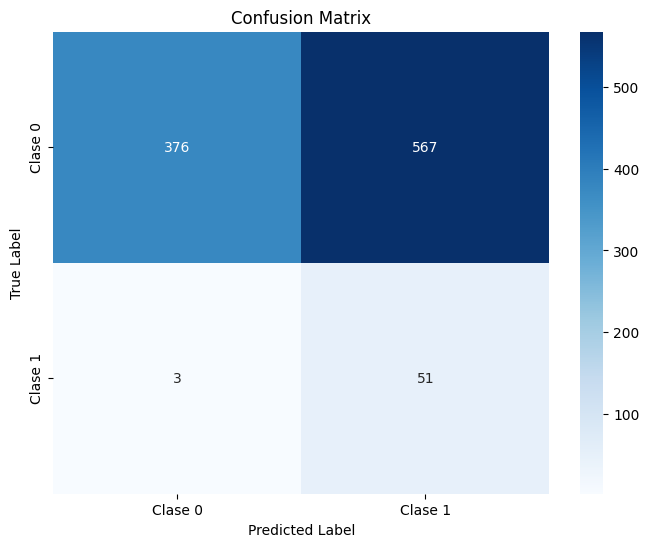

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.40      0.57       943
           1       0.08      0.94      0.15        54

    accuracy                           0.43       997
   macro avg       0.54      0.67      0.36       997
weighted avg       0.94      0.43      0.55       997



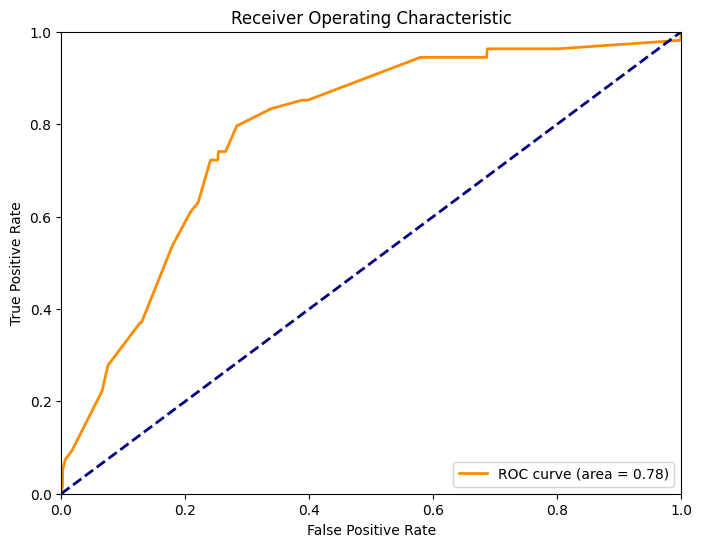

In [35]:
plt.figure(figsize=(8,6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import optuna

import torch.nn as nn
import torch.optim as optim

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definir la red neuronal
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Definir la función objetivo para Optuna
def objective(trial):
    input_dim = X_train.shape[1]
    hidden_dim = trial.suggest_int('hidden_dim', 10, 100)
    output_dim = 1
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_epochs = trial.suggest_int('num_epochs', 10, 100)

    model = Net(input_dim, hidden_dim, output_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            y_pred.extend(outputs.numpy())
            y_true.extend(y_batch.numpy())

    y_pred = (np.array(y_pred) > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

# Crear el estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Obtener los mejores hiperparámetros
best_params = study.best_params

# Entrenar el modelo final con los mejores hiperparámetros
input_dim = X_train.shape[1]
hidden_dim = best_params['hidden_dim']
output_dim = 1
learning_rate = best_params['learning_rate']
num_epochs = best_params['num_epochs']

final_model = Net(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    final_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

# Evaluar el modelo final
final_model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = final_model(X_batch)
        y_pred.extend(outputs.numpy())
        y_true.extend(y_batch.numpy())

y_pred = (np.array(y_pred) > 0.5).astype(int)
accuracy_final = accuracy_score(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

print(f"Precisión del modelo final: {accuracy_final}")
print("Reporte de clasificación:\n", class_report)

[I 2024-10-20 02:32:08,417] A new study created in memory with name: no-name-02cef3be-f5b3-4f80-a413-5957f2eb6acd
[I 2024-10-20 02:32:43,561] Trial 0 finished with value: 0.7392176529588766 and parameters: {'hidden_dim': 62, 'learning_rate': 0.0013713597065634889, 'num_epochs': 68}. Best is trial 0 with value: 0.7392176529588766.
[I 2024-10-20 02:33:10,244] Trial 1 finished with value: 0.7331995987963892 and parameters: {'hidden_dim': 22, 'learning_rate': 0.000811415065863454, 'num_epochs': 81}. Best is trial 0 with value: 0.7392176529588766.
[I 2024-10-20 02:33:13,232] Trial 2 finished with value: 0.7552657973921765 and parameters: {'hidden_dim': 35, 'learning_rate': 0.012640379743551066, 'num_epochs': 10}. Best is trial 2 with value: 0.7552657973921765.
[I 2024-10-20 02:33:33,076] Trial 3 finished with value: 0.7392176529588766 and parameters: {'hidden_dim': 19, 'learning_rate': 0.006466157794898142, 'num_epochs': 67}. Best is trial 2 with value: 0.7552657973921765.
[I 2024-10-20 02:

Precisión del modelo final: 0.7181544633901705
Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.98      0.72      0.83       943
         1.0       0.13      0.76      0.23        54

    accuracy                           0.72       997
   macro avg       0.56      0.74      0.53       997
weighted avg       0.94      0.72      0.80       997

